## Description of Notebook

The notebook is used to test ML approach on the VDF statistical momenta, anisotropies, and particle fraction numbers

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
import seaborn as sns
import pandas as pd

In [2]:
def outputclass_analysis(test_labels, predicted_labels, output_score=''):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    print("------------ SUMMARY OF CLASSIFICATION RESULTS ----------------")
    print("TP = "+str(tp))
    print("TN = "+str(tn))
    print("FP = "+str(fp))
    print("FN = "+str(fn))
    precision = tp/(tp+fp) if ((tp+fp) != 0) else -999.9
    recall = tp/(tp+fn) if ((tp+fn) != 0) else -999.9
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn) if (((tp+fn) != 0) and ((fp+tn) != 0)) else -999.9
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))
    print("Accuracy = "+str(acc))
    print("TSS = "+str(tss))
    print("HSS = "+str(hss))
    if (output_score == 'TSS'): return tss
    if (output_score == 'HSS'): return hss
    if (output_score == 'precision'): return precision
    if (output_score == 'accuracy'): return acc
    return

def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    matrix_elements = confusion_matrix(test_labels, predicted_labels, labels=[0, 1]).ravel()
    tn, fp, fn, tp = matrix_elements
    precision = tp/(tp+fp) if ((tp+fp) != 0) else -999.9
    recall = tp/(tp+fn) if ((tp+fn) != 0) else -999.9
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn) if (((tp+fn) != 0) and ((fp+tn) != 0)) else -999.9
    return tp, tn, fp, fn, acc, tss

## Test 1. Preparation and testing of the data set (thres 0.001, unified labels, random split).

We have previously determined that the threshold of 0.001 provides the most reasonably-partitioned data set in case the labels for magnetic energy evolution and anisotropies are unified. The new elements here will be hyperparameter tuning for ML.

First, we load the data set, normalize it, and do some visualizations

In [3]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 1596
Among them unstable (positive) samples: 418


In [4]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

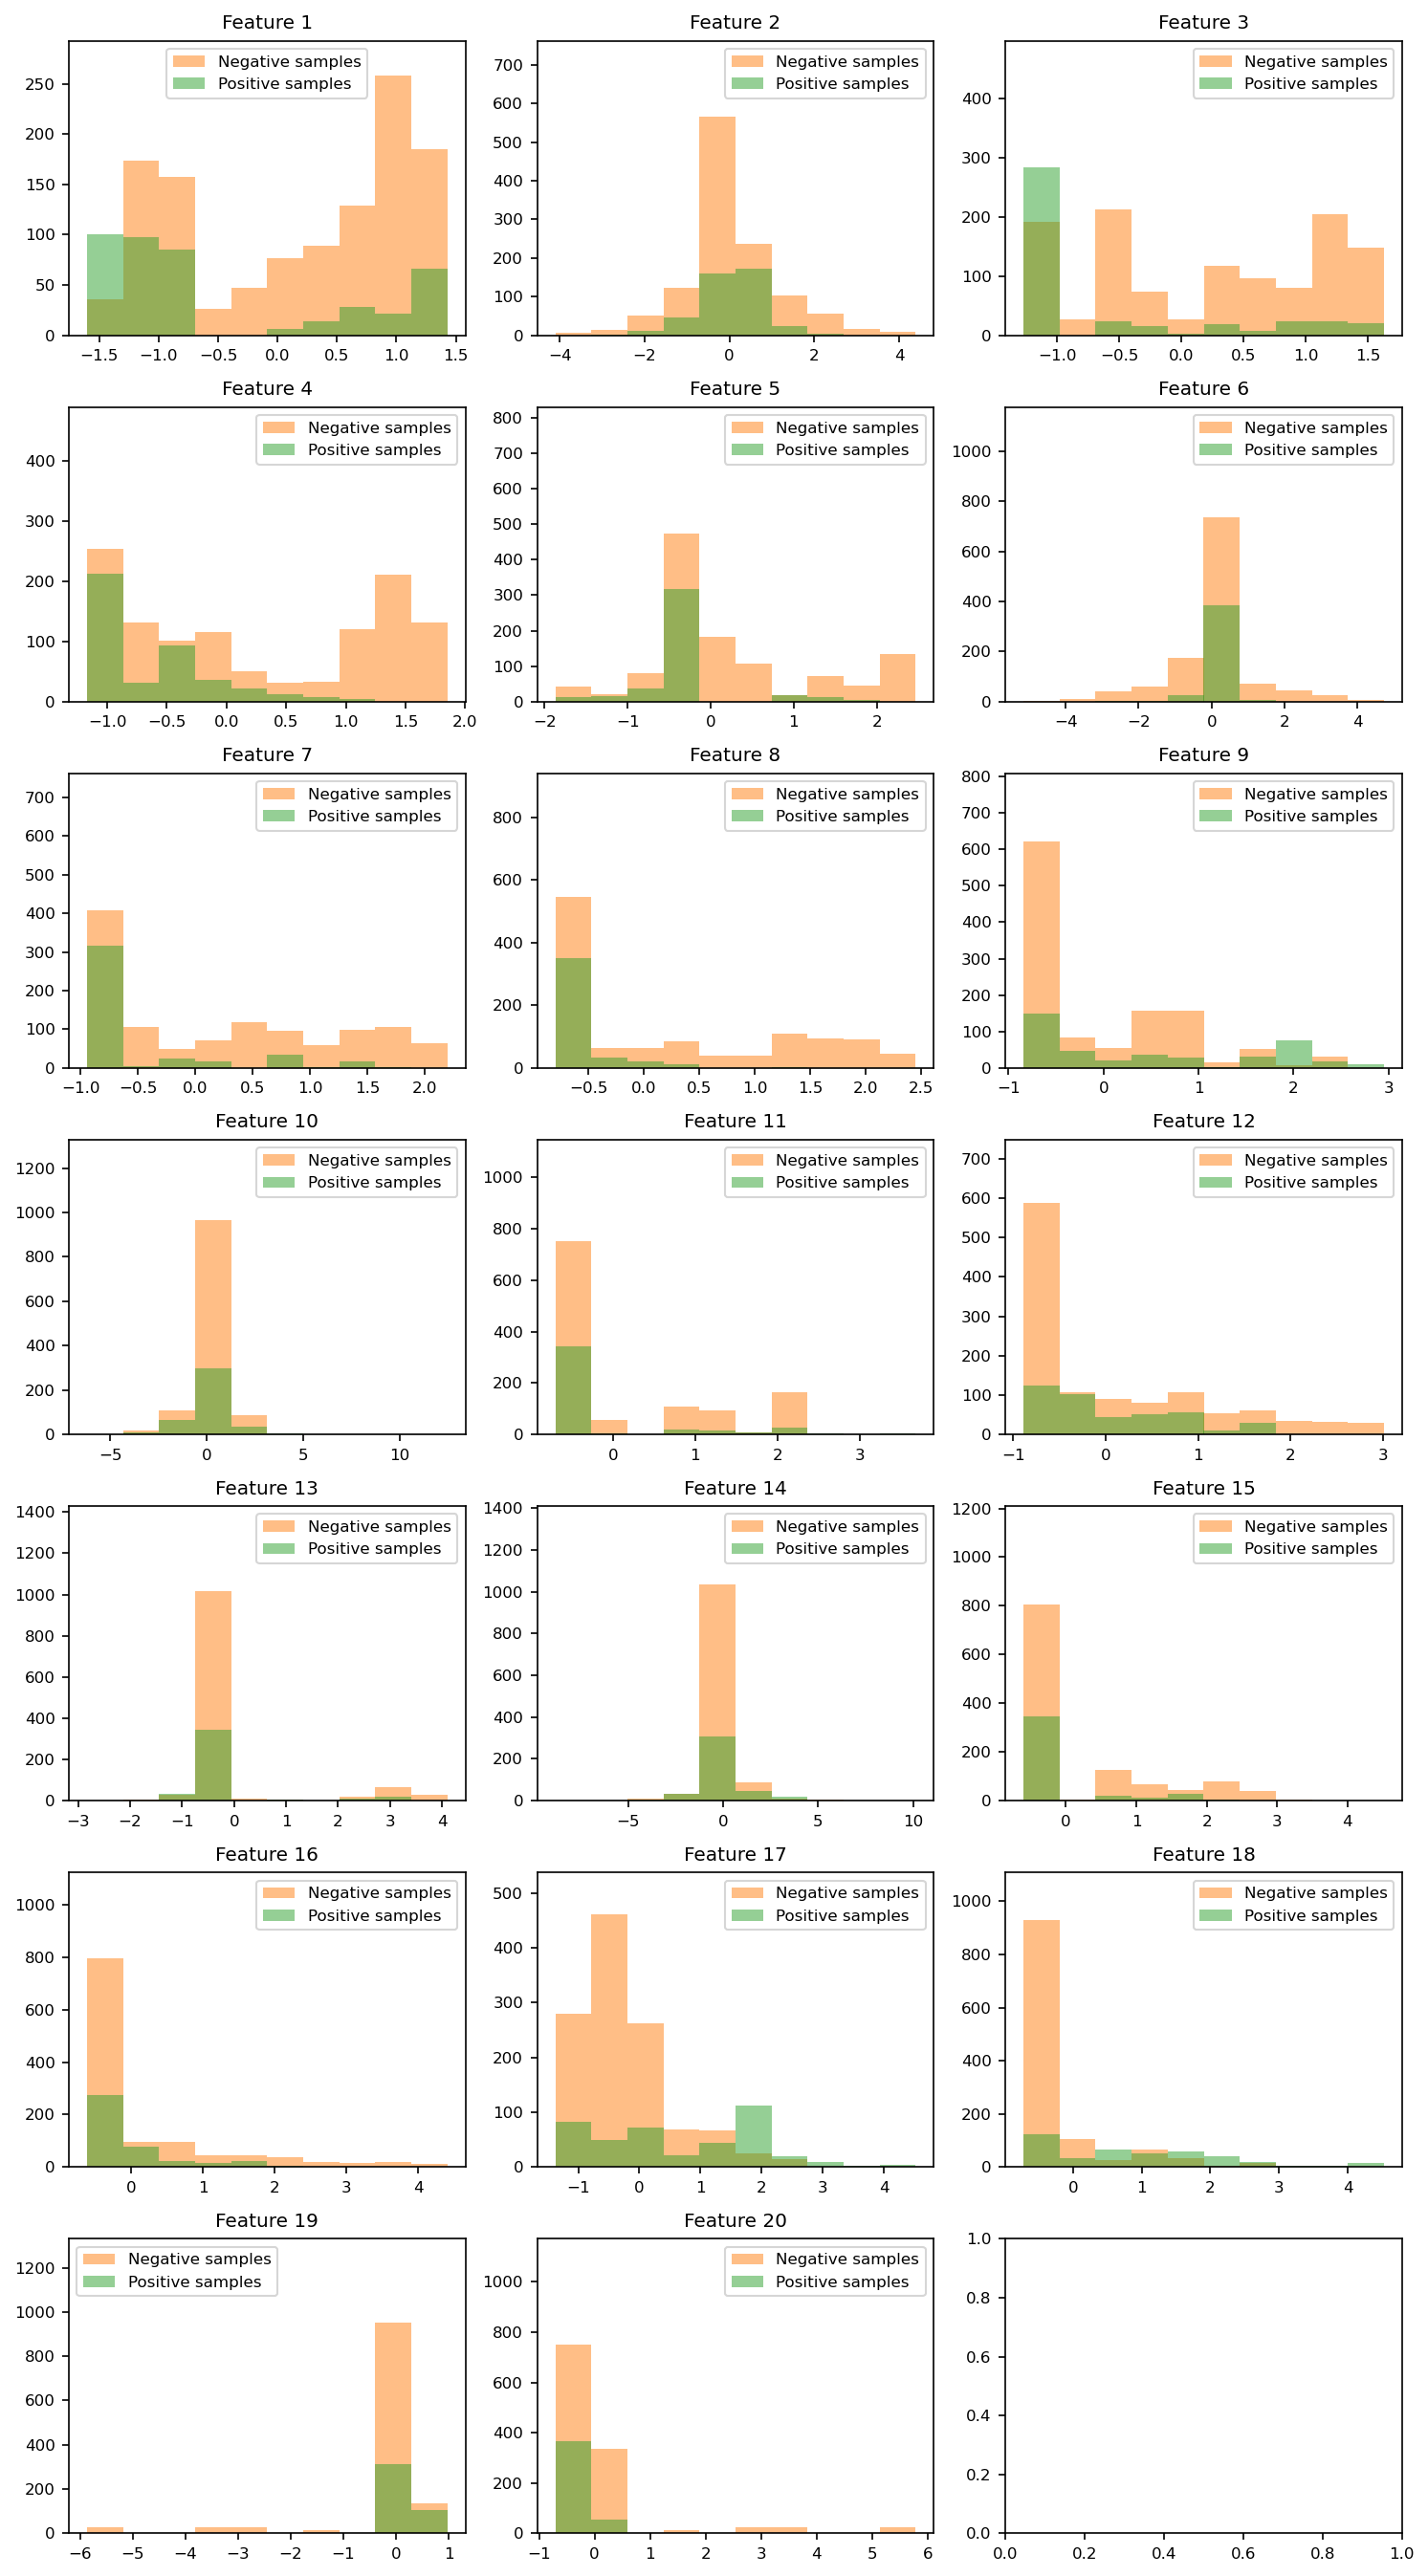

In [5]:
index_0 = np.where(labels_allmoments == 0)[0]
index_1 = np.where(labels_allmoments == 1)[0]

matplotlib.rcParams.update({'font.size':8})
im, ax = plt.subplots(7, 3, figsize = (10, 18), dpi=150)
for i in range (0, 7, 1):
    for j in range (0, 3, 1):
        if ((i == 6) and (j == 2)): continue
        hist, bins, patches = ax[i,j].hist(featurevector_allmoments[:,i*3+j], bins=10, alpha=0.00)
        ax[i,j].hist(featurevector_allmoments[index_0,i*3+j], bins=bins, label='Negative samples', alpha=0.50)
        ax[i,j].hist(featurevector_allmoments[index_1,i*3+j], bins=bins, label='Positive samples', alpha=0.50)
        ax[i,j].set(title='Feature '+str(i*3+j+1))
        ax[i,j].legend()

plt.tight_layout()
plt.show()

In [6]:
data_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=0)

In [7]:
data_split.split(labels_allmoments)

<generator object BaseShuffleSplit.split at 0x00000222D35BDCF0>

Next, we introduce the grid search procedure to determined the optimal parameters for the machine learning. The data set will be split according to the data_split function defined above. The parameters to test are different for different models, and therefore the dictionaries are defined differently.

### Case 1. kNN classifier.

In [8]:
# parameter grid
param_grid = {'n_neighbors': [2, 5, 10, 25], \
              'p': [1, 2]}

# classifier and gridsearch
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=1)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(labels_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameters found:  {'n_neighbors': 5, 'p': 1}
TP = 105.1+/-4.763402145525822
TN = 377.8+/-3.1240998703626617
FP = 14.9+/-2.947880594596735
FN = 29.2+/-3.4583232931581165
Acc = 0.9163187855787476+/-0.007371128880286528
TSS = 0.7447115804936696+/-0.024797477333641203


### Case 2. Support vector classifier with RBF kernel

In [9]:
# parameter grid
param_grid = {'kernel': ['rbf'], \
              'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], \
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 'scale'], \
              'class_weight': [None, 'balanced']}

# classifier and gridsearch
clf = SVC()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=None,

[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s


[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END C=0.01, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] E

[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0

[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ....C=1.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weight=None, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..C=1.0, class_weig

[CV] END ..C=10.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_weight=None, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END ...C=10.0, class_we

[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=None, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_weight=None, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .C=100.0, class_wei

[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=100.0, class_weight=balanced, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=None, gamma=0.0001, kernel=rbf; total time=

[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=   0.0s
[CV] END C=1000.0, class_weight=balanced, gamma=1.0, kernel=rbf; total time=

[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END C=10000.0, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END C=10000.0, class_weight=balanced, gam

### Case 3. Random Forest

In [10]:
# parameter grid
param_grid = {'n_estimators': [10,50,100,200], \
              'max_depth': [None, 2, 5, 10, 25], \
              'class_weight': [None, 'balanced']}

# classifier and gridsearch
clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END .class_weight=None, max_depth=None, n_estimators=50; total time=   0.2s
[CV] END .class_weight=None, max_depth=None, n

[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   0.9s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   1.1s
[CV] END ...class_weight=None, max_depth=5, n_estimators=200; total time=   1.1s
[CV] END ...class_weight=Non

[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, n_estimators=50; total time=

[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   0.9s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.2s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   0.8s
[CV] END class_weight=balanced, max_depth=5, n_estimators=200; total time=   0.9s
[CV] END class_w

### Case 4. Neural Networks

In [11]:
# parameter grid
param_grid = {'hidden_layer_sizes': [(10,), (50,), (200,), (500,)], \
              'max_iter': [100, 250, 1000, 2500, 10000]}

# classifier and gridsearch
clf = MLPClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=data_split, verbose=2)
grid_search.fit(featurevector_allmoments, labels_allmoments)
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(**best_params)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s
[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s
[CV] END .............hidden_layer_sizes=(10,), max_iter=100; total time=   0.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(10,), max_iter=250; total time=   0.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.9s
[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   2.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.9s
[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.8s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(10,), max_iter=1000; total time=   1.9s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.7s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.7s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.0s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.3s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   1.9s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.7s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.4s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.3s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.0s
[CV] END ............hidden_layer_sizes=(10,), max_iter=2500; total time=   2.1s
[CV] END ...........hidden_layer_sizes=(10,), max_iter=10000; total time=   2.3s
[CV] END ...........hidden_l

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=100; total time=   0.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   1.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .............hidden_layer_sizes=(50,), max_iter=250; total time=   0.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.6s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.2s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.6s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   4.1s
[CV] END ............hidden_layer_sizes=(50,), max_iter=1000; total time=   3.9s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   4.7s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   3.0s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   3.7s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   4.0s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   4.5s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   4.1s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   4.3s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   4.2s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.0s
[CV] END ............hidden_layer_sizes=(50,), max_iter=2500; total time=   5.1s
[CV] END ...........hidden_l

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   1.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=100; total time=   0.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(200,), max_iter=250; total time=   2.4s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.4s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   5.7s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   5.3s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   6.5s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   6.0s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   4.9s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   6.1s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   6.3s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   6.7s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=1000; total time=   7.8s
[CV] END ...........hidden_layer_sizes=(200,), max_iter=2500; total time=   7.7s
[CV] END ...........hidden_l

C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   2.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=100; total time=   1.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.3s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   6.4s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   4.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   4.9s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.1s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.2s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   5.0s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   4.7s


C:\Users\Slava\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END ............hidden_layer_sizes=(500,), max_iter=250; total time=   4.9s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  11.7s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  13.2s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  10.5s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  10.9s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   9.5s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=  11.2s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   9.1s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   8.1s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   9.9s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=1000; total time=   7.7s
[CV] END ...........hidden_layer_sizes=(500,), max_iter=2500; total time=   8.3s
[CV] END ...........hidden_l

### Visualizations for the best-fitted classifiers

In [12]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(labels_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(n_neighbors=5, p=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_knn = np.copy(tp)
tn_knn = np.copy(tn)
fp_knn = np.copy(fp)
fn_knn = np.copy(fn)
acc_knn = np.copy(acc)
tss_knn = np.copy(tss)

TP = 105.1+/-4.763402145525822
TN = 377.8+/-3.1240998703626617
FP = 14.9+/-2.947880594596735
FN = 29.2+/-3.4583232931581165
Acc = 0.9163187855787476+/-0.007371128880286528
TSS = 0.7447115804936696+/-0.024797477333641203


In [13]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(C=10000.0, class_weight=None, gamma='scale', kernel='rbf')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_svm = np.copy(tp)
tn_svm = np.copy(tn)
fp_svm = np.copy(fp)
fn_svm = np.copy(fn)
acc_svm = np.copy(acc)
tss_svm = np.copy(tss)

TP = 115.7+/-7.694803441284254
TN = 371.7+/-5.1
FP = 21.0+/-3.521363372331802
FN = 18.6+/-4.476605857119878
Acc = 0.9248576850094876+/-0.011485955180585624
TSS = 0.8073503524398994+/-0.03826377706549459


In [14]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print ("Processing partition " + str(i))
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(class_weight = None, max_depth = 25, n_estimators = 200, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_rf = np.copy(tp)
tn_rf = np.copy(tn)
fp_rf = np.copy(fp)
fn_rf = np.copy(fn)
acc_rf = np.copy(acc)
tss_rf = np.copy(tss)

Processing partition 0
Processing partition 1
Processing partition 2
Processing partition 3
Processing partition 4
Processing partition 5
Processing partition 6
Processing partition 7
Processing partition 8
Processing partition 9
TP = 122.2+/-5.827520913733386
TN = 385.9+/-4.988987873306569
FP = 6.8+/-2.3579652245103193
FN = 12.1+/-3.5902646142032486
Acc = 0.9641366223908919+/-0.0067061089362703144
TSS = 0.8924483526790088+/-0.02588008876718904


In [15]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print ("Processing partition " + str(i))
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(hidden_layer_sizes = (500,), max_iter=2500, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_mlp = np.copy(tp)
tn_mlp = np.copy(tn)
fp_mlp = np.copy(fp)
fn_mlp = np.copy(fn)
acc_mlp = np.copy(acc)
tss_mlp = np.copy(tss)

Processing partition 0
Processing partition 1
Processing partition 2
Processing partition 3
Processing partition 4
Processing partition 5
Processing partition 6
Processing partition 7
Processing partition 8
Processing partition 9
TP = 110.5+/-4.716990566028302
TN = 375.4+/-4.63033476111609
FP = 17.3+/-2.0518284528683193
FN = 23.8+/-2.8213471959331766
Acc = 0.9220113851992411+/-0.005845511119828977
TSS = 0.7786935207599172+/-0.020341714871177207


In [16]:
# from the CNN notebook

acc_cnn15 = np.array([0.8840579710144928, 0.9444444444444444, 0.893719806763285, 0.9347826086956522, 0.9033816425120773, \
0.9202898550724637, 0.9178743961352657, 0.9057971014492754, 0.9130434782608695, 0.9444444444444444], dtype=float)

tss_cnn15 = np.array([0.6702898550724637, 0.8508281379605597, 0.6920289855072463, 0.8253744393986405, 0.7388489016134643, \
0.804629246064623, 0.7626717062025781, 0.6847801191021531, 0.782608695652174, 0.8416481360366252], dtype=float)

acc_cnn10 = np.array([0.8985507246376812, 0.9154589371980676, 0.893719806763285, 0.9444444444444444, 0.9444444444444444, \
0.9323671497584541, 0.9251207729468599, 0.9082125603864735, 0.9323671497584541, 0.9323671497584541], dtype=float)

tss_cnn10 = np.array([0.717391304347826, 0.8160436678885826, 0.6920289855072463, 0.8632837841649508, 0.8349878254354748, \
0.8331089478044739, 0.8068710687388938, 0.7595052679798443, 0.8405797101449276, 0.8412557226945716], dtype=float)

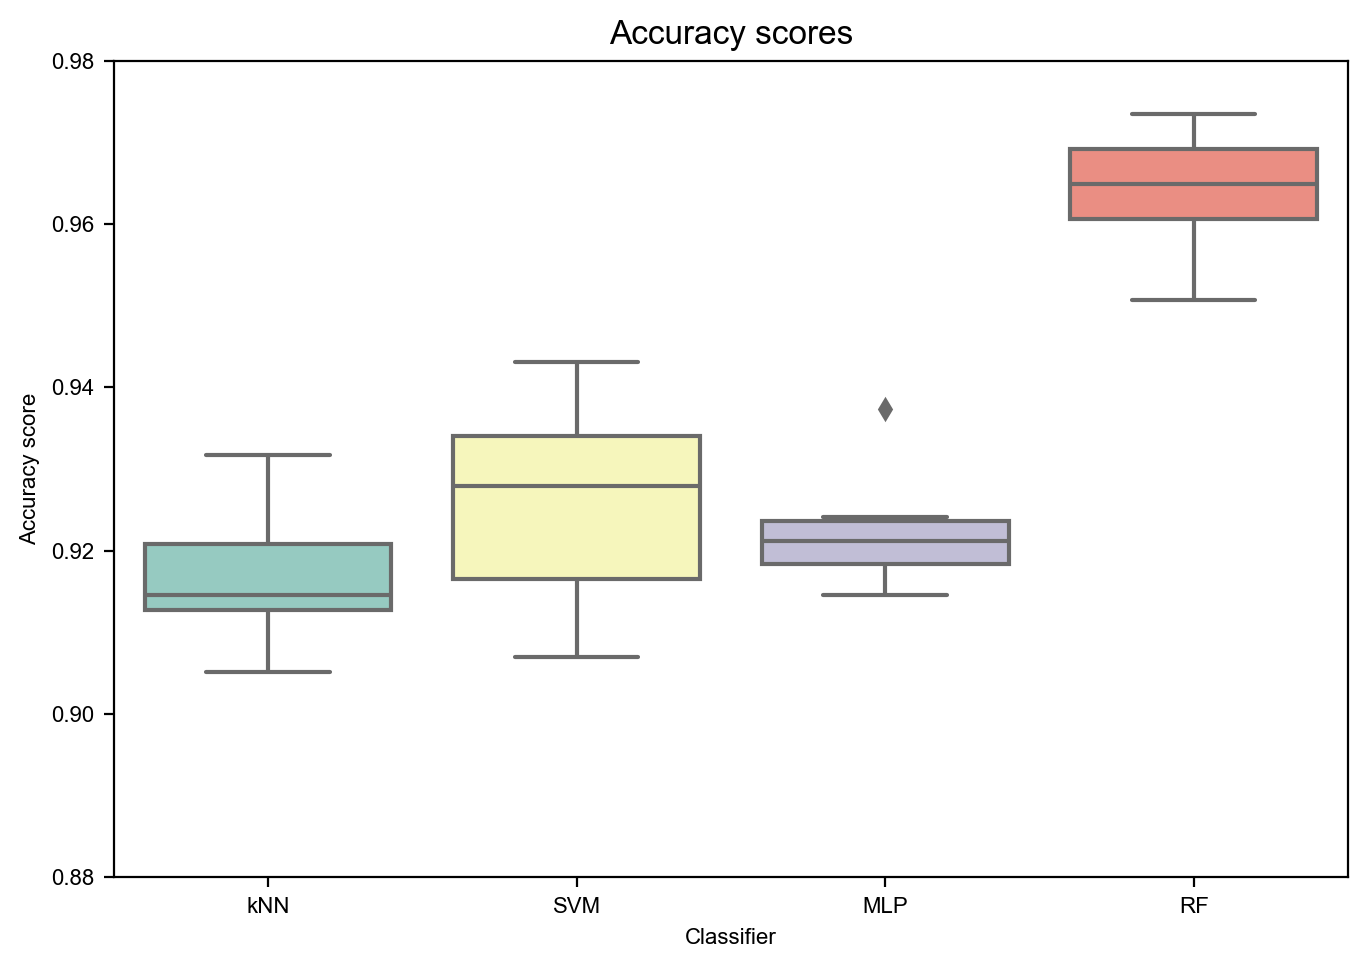

In [17]:
im, ax = plt.subplots(1, 1, figsize=(7,5), dpi=200)
sns.set(style="whitegrid")

data = {
    'kNN': acc_knn,
    'SVM': acc_svm,
    'MLP': acc_mlp,
    'RF': acc_rf
}

#, 
#    r'CNN(0.15V$_{A}$)': acc_cnn15,
#    r'CNN(0.10V$_{A}$)': acc_cnn10

df = pd.DataFrame([(group, score) for group, scores in data.items() for score in scores], \
                  columns=['Classifier', 'Accuracy score'])

ax = sns.boxplot(x='Classifier', y='Accuracy score', data=df, palette="Set3")
ax.set(xlabel='Classifier', ylabel='Accuracy score', title='Accuracy scores')
ax.set(ylim=[0.88,0.98])

plt.tight_layout()
#plt.savefig('./IEEE_visualizations/accuracy_boxplot.png')
plt.show()

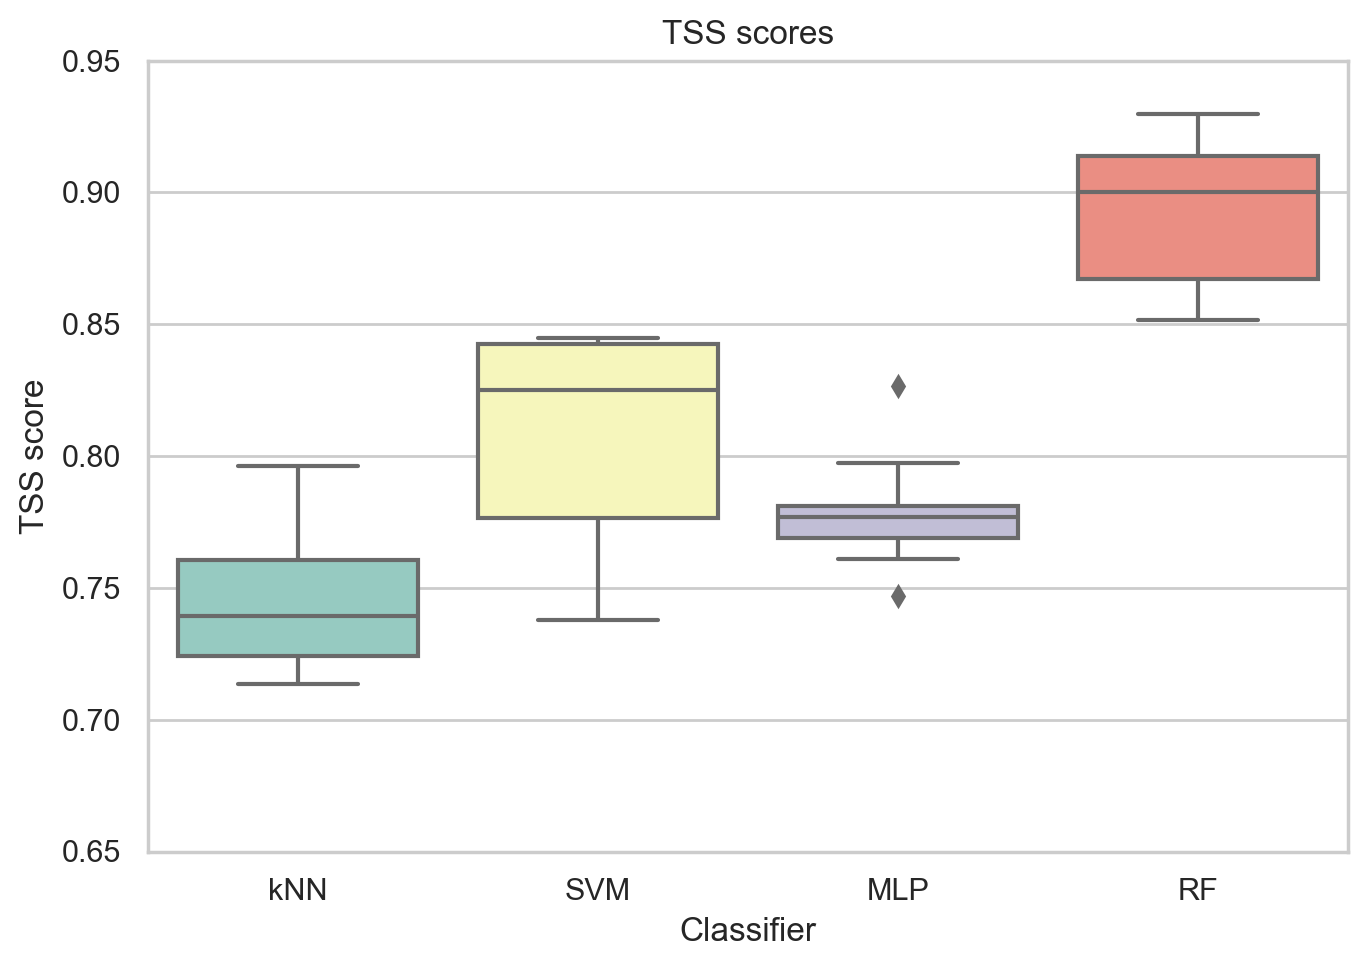

In [18]:
im, ax = plt.subplots(1, 1, figsize=(7,5), dpi=200)
sns.set(style="whitegrid")

data = {
    'kNN': tss_knn,
    'SVM': tss_svm,
    'MLP': tss_mlp,
    'RF': tss_rf
}

#, 
#    r'CNN(0.15V$_{A}$)': tss_cnn15,
#    r'CNN(0.10V$_{A}$)': tss_cnn10

df = pd.DataFrame([(group, score) for group, scores in data.items() for score in scores], \
                  columns=['Classifier', 'TSS score'])

ax = sns.boxplot(x='Classifier', y='TSS score', data=df, palette="Set3")
ax.set(xlabel='Classifier', ylabel='TSS score', title='TSS scores')
ax.set(ylim=[0.65,0.95])

plt.tight_layout()
#plt.savefig('./IEEE_visualizations/tss_boxplot.png')
plt.show()

## Test 2. Understanding the parameter space

There are several actions that could be done here, including (1) understanding what simulation runs produce the largest number of incorrect predictions, and (2) figuring out where the incorrect predictions are on the 'Brazil' plot, for the beginnning, and (3) comparison of random forest with others.

In [ ]:
# fitting 10 times and accumulating the scores for the best model
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

labels_aspredicted = []
labels_groundtruth = []

for i, split_indexes in enumerate(data_split.split(featurevector_allmoments)):
    print ("Processing partition " + str(i))
    train_index, test_index = split_indexes
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(class_weight = None, max_depth = 25, n_estimators = 200, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

tp_rf = np.copy(tp)
tn_rf = np.copy(tn)
fp_rf = np.copy(fp)
fn_rf = np.copy(fn)
acc_rf = np.copy(acc)
tss_rf = np.copy(tss)

## Test 2. Testing performance for any 'unseen' run

In [6]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_all.npy')
simnames = np.load('./mldata_vdfmoments/allsimulations.simnames_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 1253
Among them unstable (positive) samples: 398


In [7]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

In [8]:
simfiles = ['particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
    'particles.d11_A0.75Hepp_beta1_256',\
    'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
    'particles.d11_E11Ap4.3Aa1.6',\
    'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
    'particles.d11_He++A10_256_iden0eps0',\
    'particles.d11_He++v2_256_iden0eps1e-4t600',\
    'particles.d11_He++vd1.5_256_iden0eps1e-4',\
    'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
    'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
    'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
    'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
    'particles.d11_vap1.5Ap1.5Aa1rdna_0.007']

### Statistics for every run using Random Forest (best parameters)

In [9]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = RandomForestClassifier(class_weight = None, max_depth = None, n_estimators = 100, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_rf = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=40, tn=0, fp=6, fn=0 , accuracy=0.86
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=26, tn=5, fp=0, fn=15 , accuracy=0.67
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256 --------
tp=0, tn=45, fp=0, fn=3 , accuracy=0.93
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=43, fp=5, fn=0 , accuracy=0.89
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=45, tn=0, fp=1, fn=0 , accuracy=0.97
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=18, tn=6, fp=0, fn=66 , accuracy=0.26
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=50, tn=0, fp=28, fn=0

### Statistics for every run using kNN classifier (best parameters)

In [10]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = KNeighborsClassifier(n_neighbors=5, p=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_knn = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=0, fp=78, fn=0 , accuracy=0.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=35, tn=0, fp=6, fn=5 , accuracy=0.76
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=33, tn=0, fp=5, fn=8 , accuracy=0.71
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256 --------
tp=0, tn=45, fp=0, fn=3 , accuracy=0.93
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=40, fp=8, fn=0 , accuracy=0.83
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=45, tn=0, fp=1, fn=0 , accuracy=0.97
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=13, tn=5, fp=1, fn=71 , accuracy=0.2
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=33, tn=8, fp=20, fn=17 

### Statistics for every run using SVM classifier (best parameters)

In [11]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = SVC(C=10000.0, class_weight=None, gamma=0.01, kernel='rbf')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_svm = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=0, fp=78, fn=0 , accuracy=0.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=29, tn=6, fp=0, fn=11 , accuracy=0.76
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=39, tn=0, fp=5, fn=2 , accuracy=0.84
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256 --------
tp=0, tn=45, fp=0, fn=3 , accuracy=0.93
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=41, fp=7, fn=0 , accuracy=0.85
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=17, tn=1, fp=0, fn=28 , accuracy=0.39
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=21, tn=6, fp=0, fn=63 , accuracy=0.3
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=36, tn=1, fp=27, fn=1

### Statistics for every run using MLP classifier (best parameters)

In [12]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    clf = MLPClassifier(hidden_layer_sizes = (500,), max_iter=10000, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_mlp = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=38, tn=0, fp=6, fn=2 , accuracy=0.82
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=31, tn=0, fp=5, fn=10 , accuracy=0.67
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256 --------
tp=0, tn=45, fp=0, fn=3 , accuracy=0.93
-------- RUN: particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256 --------
tp=0, tn=48, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_He++A10_256_iden0eps0 --------
tp=0, tn=1, fp=0, fn=45 , accuracy=0.02
-------- RUN: particles.d11_He++v2_256_iden0eps1e-4t600 --------
tp=42, tn=1, fp=5, fn=42 , accuracy=0.47
-------- RUN: particles.d11_He++vd1.5_256_iden0eps1e-4 --------
tp=37, tn=1, fp=27, fn=13

In [22]:
accuracies_cnn15 = np.array([1. ,        1.   ,      0.7173913 , 0.13043478, 0.89130435 ,0.97916667, \
 1.     ,    0.97826087 ,0.93333333, 0.64102564 ,0.77027027 ,0.98275862, \
 0.8630137 , 0.72413793 ,0.98275862, 0.98275862 ,0.55737705, 0.70689655, \
 0.85714286 ,1.     ,    1.      ,   1.       ], dtype=float)

accuracies_cnn10 = np.array([1.      ,   1.      ,   0.56521739, 0.86956522, 0.89130435, 0.9375, \
 1.   ,      0.97826087 ,0.06666667 ,0.64102564 ,0.77027027 ,0.98275862, \
 0.8630137,  0.72413793, 0.98275862, 0.98275862, 0.91803279 ,0.70689655, \
 0.85714286 ,1.       ,  0.86363636 ,1.      ], dtype=float) 

### Visualizing a bar chart for every model

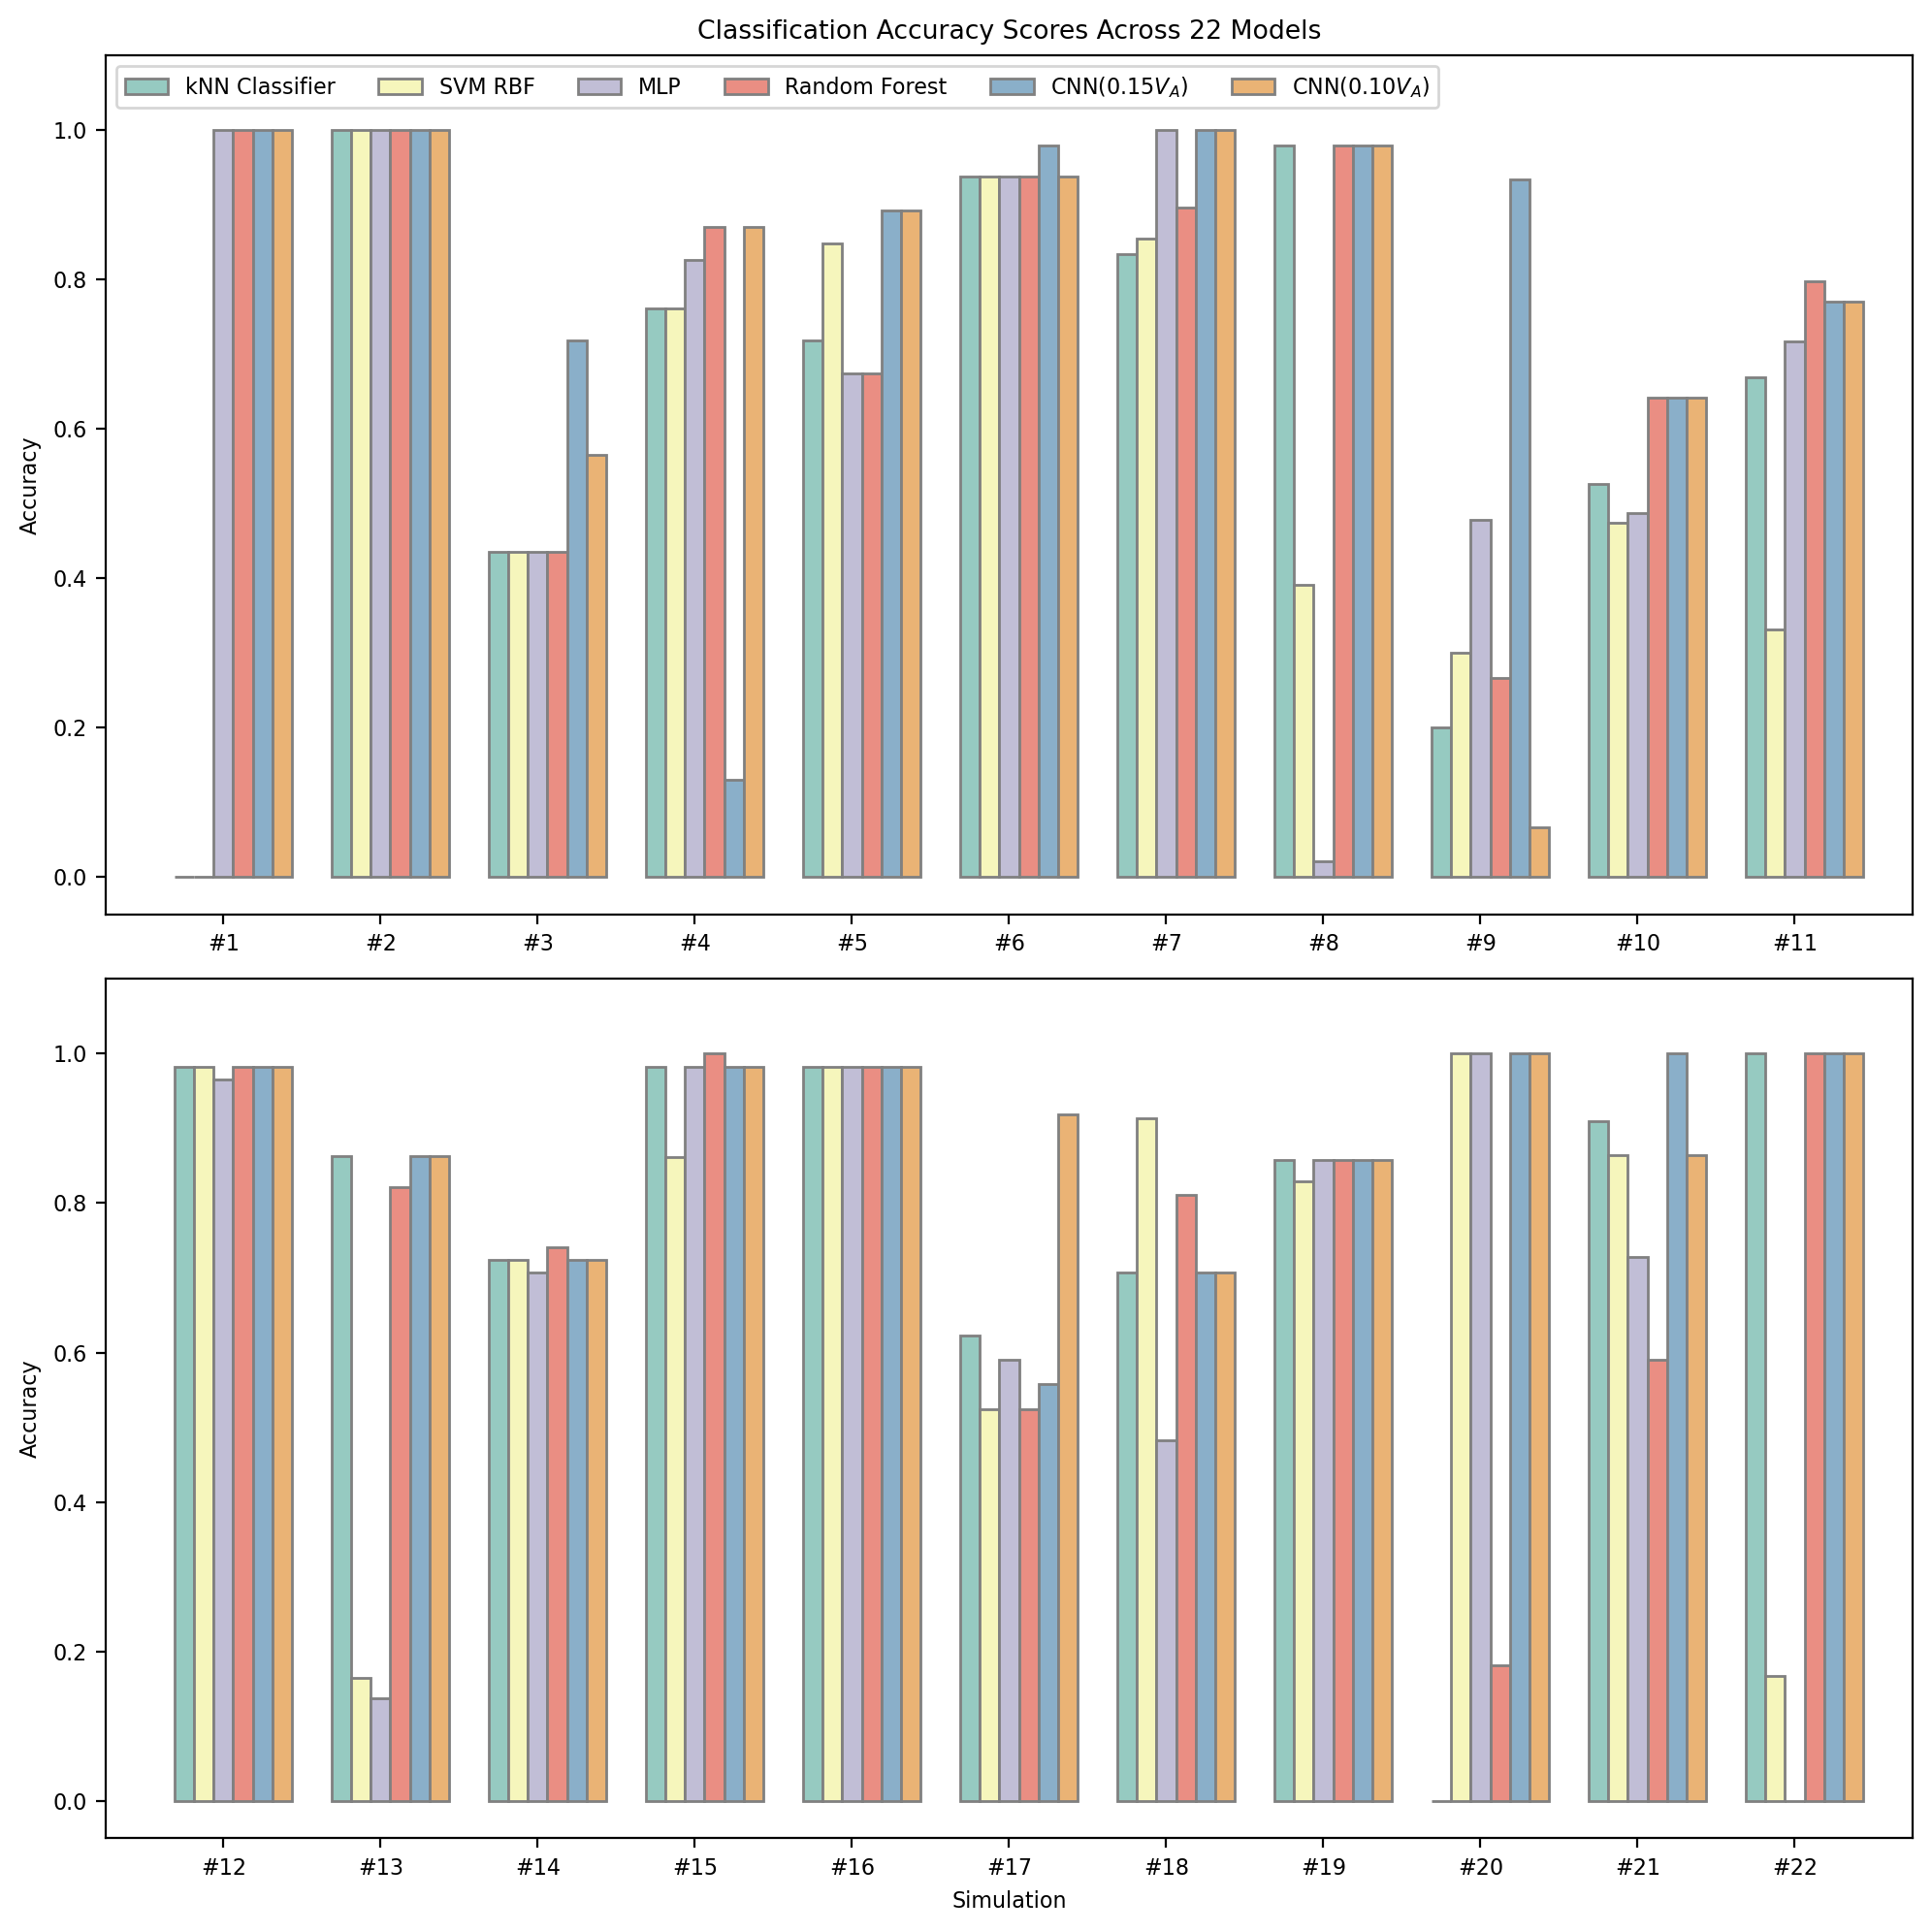

In [37]:
modelnames = np.arange(1, 23)

# Set the bar width and positions
bar_width = 0.125
r1 = np.arange(len(modelnames))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

im, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=200)



# Plotting the bar chart
ax[0].bar(r1[0:11], accuracies_knn[0:11], bar_width, color='#96cac1', edgecolor='grey', label='kNN Classifier')
ax[0].bar(r2[0:11], accuracies_svm[0:11], bar_width, color='#f6f6bc', edgecolor='grey', label='SVM RBF')
ax[0].bar(r3[0:11], accuracies_mlp[0:11], bar_width, color='#c1bed6', edgecolor='grey', label='MLP')
ax[0].bar(r4[0:11], accuracies_rf[0:11], bar_width, color='#ea8e83', edgecolor='grey', label='Random Forest')
ax[0].bar(r5[0:11], accuracies_cnn15[0:11], bar_width, color='#8aafc9', edgecolor='grey', label=r'CNN(0.15$V_{A}$)')
ax[0].bar(r6[0:11], accuracies_cnn10[0:11], bar_width, color='#eab375', edgecolor='grey', label=r'CNN(0.10$V_{A}$)')

simfilelabels_simp = ['#1', '#2', '#3', '#4', '#5', '#6', '#7', '#8', '#9', '#10', '#11']

# Adding labels and title
ax[0].set(ylabel='Accuracy', title='Classification Accuracy Scores Across 22 Models', ylim=[-0.05,1.10], xlim=[-0.5,11])
ax[0].set_xticks([r + 2*bar_width for r in range(len(modelnames[:11]))])
ax[0].set_xticklabels(simfilelabels_simp)
#plt.xticks([r + bar_width for r in range(len(modelnames[:11]))], simfilelabels_simp)

# Adding legend
ax[0].legend(ncol=6, loc=2)



# Plotting the bar chart
ax[1].bar(r1[:11], accuracies_knn[11:], bar_width, color='#96cac1', edgecolor='grey', label='kNN Classifier')
ax[1].bar(r2[:11], accuracies_svm[11:], bar_width, color='#f6f6bc', edgecolor='grey', label='SVM RBF')
ax[1].bar(r3[:11], accuracies_mlp[11:], bar_width, color='#c1bed6', edgecolor='grey', label='MLP')
ax[1].bar(r4[:11], accuracies_rf[11:], bar_width, color='#ea8e83', edgecolor='grey', label='Random Forest')
ax[1].bar(r5[:11], accuracies_cnn15[11:], bar_width, color='#8aafc9', edgecolor='grey', label=r'CNN(0.15$V_{A}$)')
ax[1].bar(r6[:11], accuracies_cnn10[11:], bar_width, color='#eab375', edgecolor='grey', label=r'CNN(0.10$V_{A}$)')

simfilelabels_simp = ['#12', '#13', '#14', '#15', '#16', '#17', '#18', '#19', '#20', '#21', '#22']

# Adding labels and title
ax[1].set(xlabel='Simulation', ylabel='Accuracy', ylim=[-0.05,1.10], xlim=[-0.5,11])
ax[1].set_xticks([r + 2*bar_width for r in range(len(modelnames[11:]))])
ax[1].set_xticklabels(simfilelabels_simp)

# Adding legend
#ax[1].legend()



plt.tight_layout()
plt.savefig('./IEEE_visualizations/accuracy_allmodels.png')
plt.show()

In [ ]:
modelnames = np.arange(1, 23)

# Set the bar width and positions
bar_width = 0.2
r1 = np.arange(len(modelnames))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

im, ax = plt.subplots(1, 1, figsize=(10, 16), dpi=200)

# Plotting the bar chart
ax.barh(r1, accuracies_rf, bar_width, color='b', edgecolor='grey', label='Random Forest')
ax.barh(r2, accuracies_knn, bar_width, color='g', edgecolor='grey', label='kNN Classifier')
ax.barh(r3, accuracies_svm, bar_width, color='r', edgecolor='grey', label='SVM RBF')
ax.barh(r4, accuracies_mlp, bar_width, color='c', edgecolor='grey', label='Neural Network')

# Adding labels and title
#ax.set(xlabel='Model', ylabel='Accuracy', title='Model Accuracy Scores Across 22 Models', ylim=[-0.05,1.05], xlim=[-0.5,23.5])
#plt.xticks([r + bar_width for r in range(len(modelnames))], simfiles, rotation=90)

# Adding legend
ax.legend()

plt.tight_layout()
plt.show()

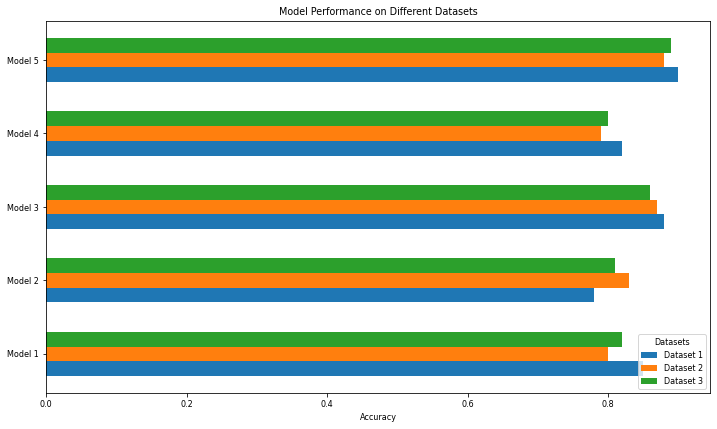

In [15]:
accuracies = np.array([
    [0.85, 0.80, 0.82],  # Model 1
    [0.78, 0.83, 0.81],  # Model 2
    [0.88, 0.87, 0.86],  # Model 3
    [0.82, 0.79, 0.80],  # Model 4
    [0.90, 0.88, 0.89]   # Model 5
])

# Model and Dataset labels
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
datasets = ['Dataset 1', 'Dataset 2', 'Dataset 3']

# Plotting parameters
bar_width = 0.2
index = np.arange(len(models))  # Model positions on the y-axis

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot horizontal bars for each dataset
for i, dataset in enumerate(datasets):
    # Offset the bars for each dataset on the same y position
    ax.barh(index + i * bar_width, accuracies[:, i], bar_width, label=dataset)

# Add labels, title, and legend
ax.set_xlabel('Accuracy')
ax.set_title('Model Performance on Different Datasets')
ax.set_yticks(index + bar_width)  # Set y-axis ticks in the middle of the group
ax.set_yticklabels(models)  # Label the y-axis with model names
ax.legend(title="Datasets")

# Show the plot
plt.tight_layout()
plt.show()

## Test 3. Trying the same exercise as previously but with oversampling with ADASYN (Adaptive Synthetic Sampling)

In [40]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_all.npy')
simnames = np.load('./mldata_vdfmoments/allsimulations.simnames_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 1253
Among them unstable (positive) samples: 398


In [41]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

In [42]:
simfiles = ['particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
    'particles.d11_A0.75Hepp_beta1_256',\
    'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
    'particles.d11_E11Ap4.3Aa1.6',\
    'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
    'particles.d11_He++A10_256_iden0eps0',\
    'particles.d11_He++v2_256_iden0eps1e-4t600',\
    'particles.d11_He++vd1.5_256_iden0eps1e-4',\
    'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
    'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
    'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
    'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
    'particles.d11_vap1.5Ap1.5Aa1rdna_0.007']

### Statistics for every run with ADASYN

In [43]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    print('-------- RUN: ' + simfile + ' --------')
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    print('Before resampling: total features:' + str(len(f_train)) + ', unstable:' + str(np.sum(f_train)))
    adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5, random_state=1)
    X_resampled, f_resampled = adasyn.fit_resample(X_train, f_train)
    print('After resampling: total features:' + str(len(f_resampled)) + ', unstable:' + str(np.sum(f_resampled)))
    clf = RandomForestClassifier(class_weight = None, max_depth = None, n_estimators = 100, random_state=1)
    clf.fit(X_resampled, f_resampled)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_rf_adasyn = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
Before resampling: total features:1175, unstable:398
After resampling: total features:1584, unstable:807
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
Before resampling: total features:1207, unstable:398
After resampling: total features:1656, unstable:847
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
Before resampling: total features:1207, unstable:378
After resampling: total features:1631, unstable:802
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
Before resampling: total features:1207, unstable:358
After resampling: total features:1678, unstable:829
tp=40, tn=0, fp=6, fn=0 , accuracy=0.86
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
Before resampling: total features:1207, unstable:357
After resampling: total features:1703, unstable:853
tp=33, tn=5, fp=0, fn=8 , acc

In [44]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    print('Before resampling: total features:' + str(len(f_train)) + ', unstable:' + str(np.sum(f_train)))
    adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5, random_state=1)
    X_resampled, f_resampled = adasyn.fit_resample(X_train, f_train)
    print('After resampling: total features:' + str(len(f_resampled)) + ', unstable:' + str(np.sum(f_resampled)))
    clf = KNeighborsClassifier(n_neighbors=5, p=1)
    clf.fit(X_resampled, f_resampled)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_knn_adasyn = np.copy(accuracies)

Before resampling: total features:1175, unstable:398
After resampling: total features:1584, unstable:807
-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=0, fp=78, fn=0 , accuracy=0.0
Before resampling: total features:1207, unstable:398
After resampling: total features:1656, unstable:847
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
Before resampling: total features:1207, unstable:378
After resampling: total features:1631, unstable:802
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
Before resampling: total features:1207, unstable:358
After resampling: total features:1678, unstable:829
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=39, tn=0, fp=6, fn=1 , accuracy=0.84
Before resampling: total features:1207, unstable:357
After resampling: total features:1703, unstable:853
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=35, tn=0, fp=5, fn=6 , acc

In [45]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    print('Before resampling: total features:' + str(len(f_train)) + ', unstable:' + str(np.sum(f_train)))
    adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5, random_state=1)
    X_resampled, f_resampled = adasyn.fit_resample(X_train, f_train)
    print('After resampling: total features:' + str(len(f_resampled)) + ', unstable:' + str(np.sum(f_resampled)))
    clf = SVC(C=10000.0, class_weight=None, gamma=0.01, kernel='rbf')
    clf.fit(X_resampled, f_resampled)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_svm_adasyn = np.copy(accuracies)

Before resampling: total features:1175, unstable:398
After resampling: total features:1584, unstable:807
-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=0, fp=78, fn=0 , accuracy=0.0
Before resampling: total features:1207, unstable:398
After resampling: total features:1656, unstable:847
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
Before resampling: total features:1207, unstable:378
After resampling: total features:1631, unstable:802
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
Before resampling: total features:1207, unstable:358
After resampling: total features:1678, unstable:829
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=24, tn=6, fp=0, fn=16 , accuracy=0.65
Before resampling: total features:1207, unstable:357
After resampling: total features:1703, unstable:853
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=38, tn=0, fp=5, fn=3 , ac

In [46]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    print('Before resampling: total features:' + str(len(f_train)) + ', unstable:' + str(np.sum(f_train)))
    adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5, random_state=1)
    X_resampled, f_resampled = adasyn.fit_resample(X_train, f_train)
    print('After resampling: total features:' + str(len(f_resampled)) + ', unstable:' + str(np.sum(f_resampled)))
    clf = MLPClassifier(hidden_layer_sizes = (500,), max_iter=10000, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_mlp_adasyn = np.copy(accuracies)

Before resampling: total features:1175, unstable:398
After resampling: total features:1584, unstable:807
-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
Before resampling: total features:1207, unstable:398
After resampling: total features:1656, unstable:847
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
Before resampling: total features:1207, unstable:378
After resampling: total features:1631, unstable:802
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
Before resampling: total features:1207, unstable:358
After resampling: total features:1678, unstable:829
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=38, tn=0, fp=6, fn=2 , accuracy=0.82
Before resampling: total features:1207, unstable:357
After resampling: total features:1703, unstable:853
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=31, tn=0, fp=5, fn=10 , ac

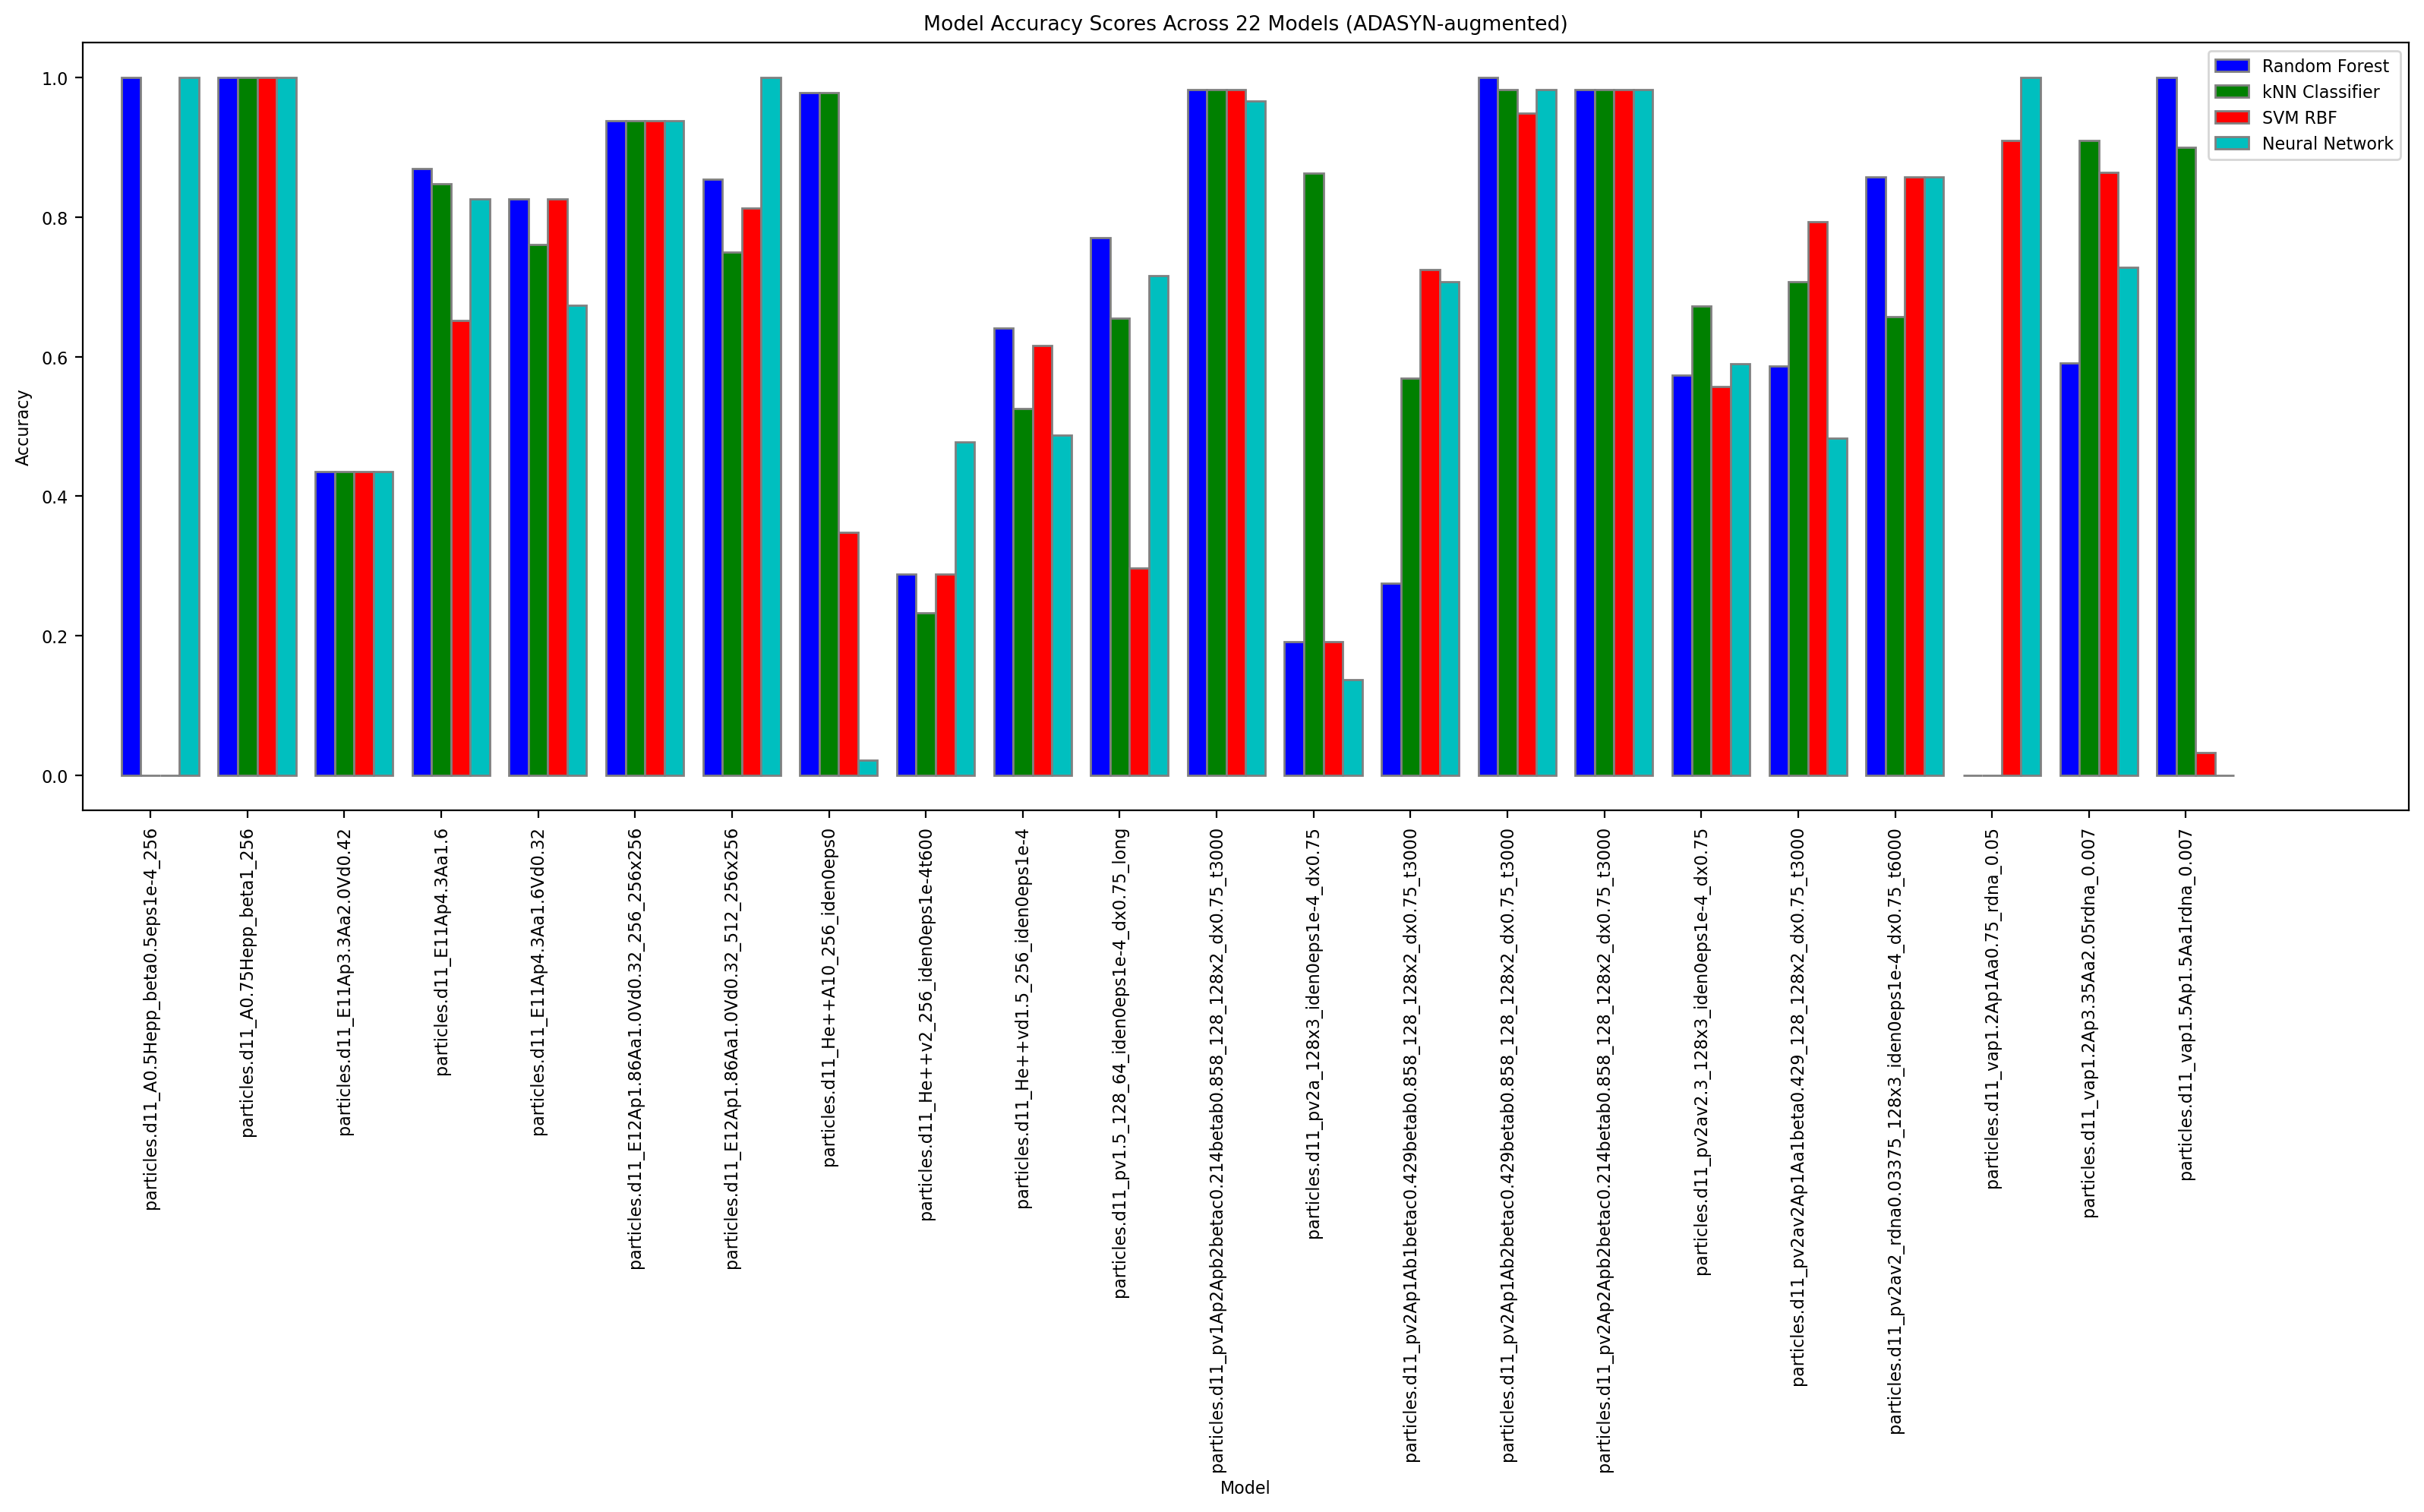

In [47]:
modelnames = np.arange(1, 23)

# Set the bar width and positions
bar_width = 0.2
r1 = np.arange(len(modelnames))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

im, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=200)

# Plotting the bar chart
ax.bar(r1, accuracies_rf_adasyn, color='b', width=bar_width, edgecolor='grey', label='Random Forest')
ax.bar(r2, accuracies_knn_adasyn, color='g', width=bar_width, edgecolor='grey', label='kNN Classifier')
ax.bar(r3, accuracies_svm_adasyn, color='r', width=bar_width, edgecolor='grey', label='SVM RBF')
ax.bar(r4, accuracies_mlp_adasyn, color='c', width=bar_width, edgecolor='grey', label='Neural Network')

# Adding labels and title
ax.set(xlabel='Model', ylabel='Accuracy', title='Model Accuracy Scores Across 22 Models (ADASYN-augmented)',\
       ylim=[-0.05,1.05], xlim=[-0.5,23.5])
plt.xticks([r + bar_width for r in range(len(modelnames))], simfiles, rotation=90)

# Adding legend
ax.legend()

plt.tight_layout()
plt.show()

## Test 3. More experimenting with ADASYN

In [3]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.featurevector_allmoments_all.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.timep_array_all.npy')
labels_an = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_an_01_all.npy')
labels_me = np.load('./mldata_vdfmoments/allsimulations.labels_allmoments_me_01_all.npy')
simnames = np.load('./mldata_vdfmoments/allsimulations.simnames_all.npy')
# merging both labels
labels_allmoments = np.copy(labels_me)
labels_allmoments[np.where(labels_an == 1)] = 1

print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 1253
Among them unstable (positive) samples: 398


In [4]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

In [5]:
simfiles = ['particles.d11_A0.5Hepp_beta0.5eps1e-4_256',\
    'particles.d11_A0.75Hepp_beta1_256',\
    'particles.d11_E11Ap3.3Aa2.0Vd0.42',\
    'particles.d11_E11Ap4.3Aa1.6',\
    'particles.d11_E11Ap4.3Aa1.6Vd0.32',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_256_256x256',\
    'particles.d11_E12Ap1.86Aa1.0Vd0.32_512_256x256',\
    'particles.d11_He++A10_256_iden0eps0',\
    'particles.d11_He++v2_256_iden0eps1e-4t600',\
    'particles.d11_He++vd1.5_256_iden0eps1e-4',\
    'particles.d11_pv1.5_128_64_iden0eps1e-4_dx0.75_long',\
    'particles.d11_pv1Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2a_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2Ap1Ab1betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap1Ab2betac0.429betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2Ap2Apb2betac0.214betab0.858_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2.3_128x3_iden0eps1e-4_dx0.75',\
    'particles.d11_pv2av2Ap1Aa1beta0.429_128_128x2_dx0.75_t3000',\
    'particles.d11_pv2av2_rdna0.03375_128x3_iden0eps1e-4_dx0.75_t6000',\
    'particles.d11_vap1.2Ap1Aa0.75_rdna_0.05',\
    'particles.d11_vap1.2Ap3.35Aa2.05rdna_0.007',\
    'particles.d11_vap1.5Ap1.5Aa1rdna_0.007']

In [6]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    print('-------- RUN: ' + simfile + ' --------')
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    print('Before resampling: total features:' + str(len(f_train)) + ', unstable:' + str(np.sum(f_train)))
    adasyn = ADASYN(sampling_strategy='minority', n_neighbors=10, random_state=1)
    X_resampled, f_resampled = adasyn.fit_resample(X_train, f_train)
    print('After resampling: total features:' + str(len(f_resampled)) + ', unstable:' + str(np.sum(f_resampled)))
    clf = RandomForestClassifier(class_weight = None, max_depth = None, n_estimators = 100, random_state=1)
    clf.fit(X_resampled, f_resampled)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_rf_adasyn = np.copy(accuracies)

-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
Before resampling: total features:1175, unstable:398
After resampling: total features:1534, unstable:757
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
Before resampling: total features:1207, unstable:398
After resampling: total features:1596, unstable:787
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
Before resampling: total features:1207, unstable:378
After resampling: total features:1611, unstable:782
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
Before resampling: total features:1207, unstable:358
After resampling: total features:1642, unstable:793
tp=40, tn=0, fp=6, fn=0 , accuracy=0.86
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
Before resampling: total features:1207, unstable:357
After resampling: total features:1757, unstable:907
tp=27, tn=4, fp=1, fn=14 , ac

In [7]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    print('Before resampling: total features:' + str(len(f_train)) + ', unstable:' + str(np.sum(f_train)))
    adasyn = ADASYN(sampling_strategy='minority', n_neighbors=10, random_state=1)
    X_resampled, f_resampled = adasyn.fit_resample(X_train, f_train)
    print('After resampling: total features:' + str(len(f_resampled)) + ', unstable:' + str(np.sum(f_resampled)))
    clf = KNeighborsClassifier(n_neighbors=5, p=1)
    clf.fit(X_resampled, f_resampled)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_knn_adasyn = np.copy(accuracies)

Before resampling: total features:1175, unstable:398
After resampling: total features:1534, unstable:757
-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=0, fp=78, fn=0 , accuracy=0.0
Before resampling: total features:1207, unstable:398
After resampling: total features:1596, unstable:787
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
Before resampling: total features:1207, unstable:378
After resampling: total features:1611, unstable:782
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
Before resampling: total features:1207, unstable:358
After resampling: total features:1642, unstable:793
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=38, tn=0, fp=6, fn=2 , accuracy=0.82
Before resampling: total features:1207, unstable:357
After resampling: total features:1757, unstable:907
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=35, tn=0, fp=5, fn=6 , acc

In [8]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    print('Before resampling: total features:' + str(len(f_train)) + ', unstable:' + str(np.sum(f_train)))
    adasyn = ADASYN(sampling_strategy='minority', n_neighbors=10, random_state=1)
    X_resampled, f_resampled = adasyn.fit_resample(X_train, f_train)
    print('After resampling: total features:' + str(len(f_resampled)) + ', unstable:' + str(np.sum(f_resampled)))
    clf = SVC(C=10000.0, class_weight=None, gamma=0.01, kernel='rbf')
    clf.fit(X_resampled, f_resampled)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_svm_adasyn = np.copy(accuracies)

Before resampling: total features:1175, unstable:398
After resampling: total features:1534, unstable:757
-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=0, fp=78, fn=0 , accuracy=0.0
Before resampling: total features:1207, unstable:398
After resampling: total features:1596, unstable:787
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
Before resampling: total features:1207, unstable:378
After resampling: total features:1611, unstable:782
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
Before resampling: total features:1207, unstable:358
After resampling: total features:1642, unstable:793
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=20, tn=6, fp=0, fn=20 , accuracy=0.56
Before resampling: total features:1207, unstable:357
After resampling: total features:1757, unstable:907
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=38, tn=0, fp=5, fn=3 , ac

In [9]:
# organizing training and testing for every simfile in its absence
accuracies = []
for simfile in simfiles:
    train_index = np.where(simnames != simfile)[0]
    test_index = np.where(simnames == simfile)[0]
    X_train, X_test = featurevector_allmoments[train_index], featurevector_allmoments[test_index]
    f_train, f_test = labels_allmoments[train_index], labels_allmoments[test_index]
    print('Before resampling: total features:' + str(len(f_train)) + ', unstable:' + str(np.sum(f_train)))
    adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5, random_state=1)
    X_resampled, f_resampled = adasyn.fit_resample(X_train, f_train)
    print('After resampling: total features:' + str(len(f_resampled)) + ', unstable:' + str(np.sum(f_resampled)))
    clf = MLPClassifier(hidden_layer_sizes = (500,), max_iter=10000, random_state=1)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp, tn, fp, fn, acc, tss = outputclass_analysis_scorereturn(f_test, f_predicted)
    # summary for the run (printout)
    print('-------- RUN: ' + simfile + ' --------')
    print('tp=' + str(tp) + ', tn=' + str(tn) + ', fp=' + str(fp) + ', fn=' + str(fn), ', accuracy=' + str(acc)[0:4])
    accuracies.append(acc)

accuracies = np.array(accuracies, dtype='float')
print('------------------------------------------------------')
print('------------------------------------------------------')
print('Mean accuracies on unseen runs:')
print('Acc = ' + str(np.mean(accuracies))[0:4] + '+/-' + str(np.std(accuracies))[0:4])
accuracies_mlp_adasyn = np.copy(accuracies)

Before resampling: total features:1175, unstable:398
After resampling: total features:1584, unstable:807
-------- RUN: particles.d11_A0.5Hepp_beta0.5eps1e-4_256 --------
tp=0, tn=78, fp=0, fn=0 , accuracy=1.0
Before resampling: total features:1207, unstable:398
After resampling: total features:1656, unstable:847
-------- RUN: particles.d11_A0.75Hepp_beta1_256 --------
tp=0, tn=46, fp=0, fn=0 , accuracy=1.0
Before resampling: total features:1207, unstable:378
After resampling: total features:1631, unstable:802
-------- RUN: particles.d11_E11Ap3.3Aa2.0Vd0.42 --------
tp=20, tn=0, fp=26, fn=0 , accuracy=0.43
Before resampling: total features:1207, unstable:358
After resampling: total features:1678, unstable:829
-------- RUN: particles.d11_E11Ap4.3Aa1.6 --------
tp=38, tn=0, fp=6, fn=2 , accuracy=0.82
Before resampling: total features:1207, unstable:357
After resampling: total features:1703, unstable:853
-------- RUN: particles.d11_E11Ap4.3Aa1.6Vd0.32 --------
tp=31, tn=0, fp=5, fn=10 , ac

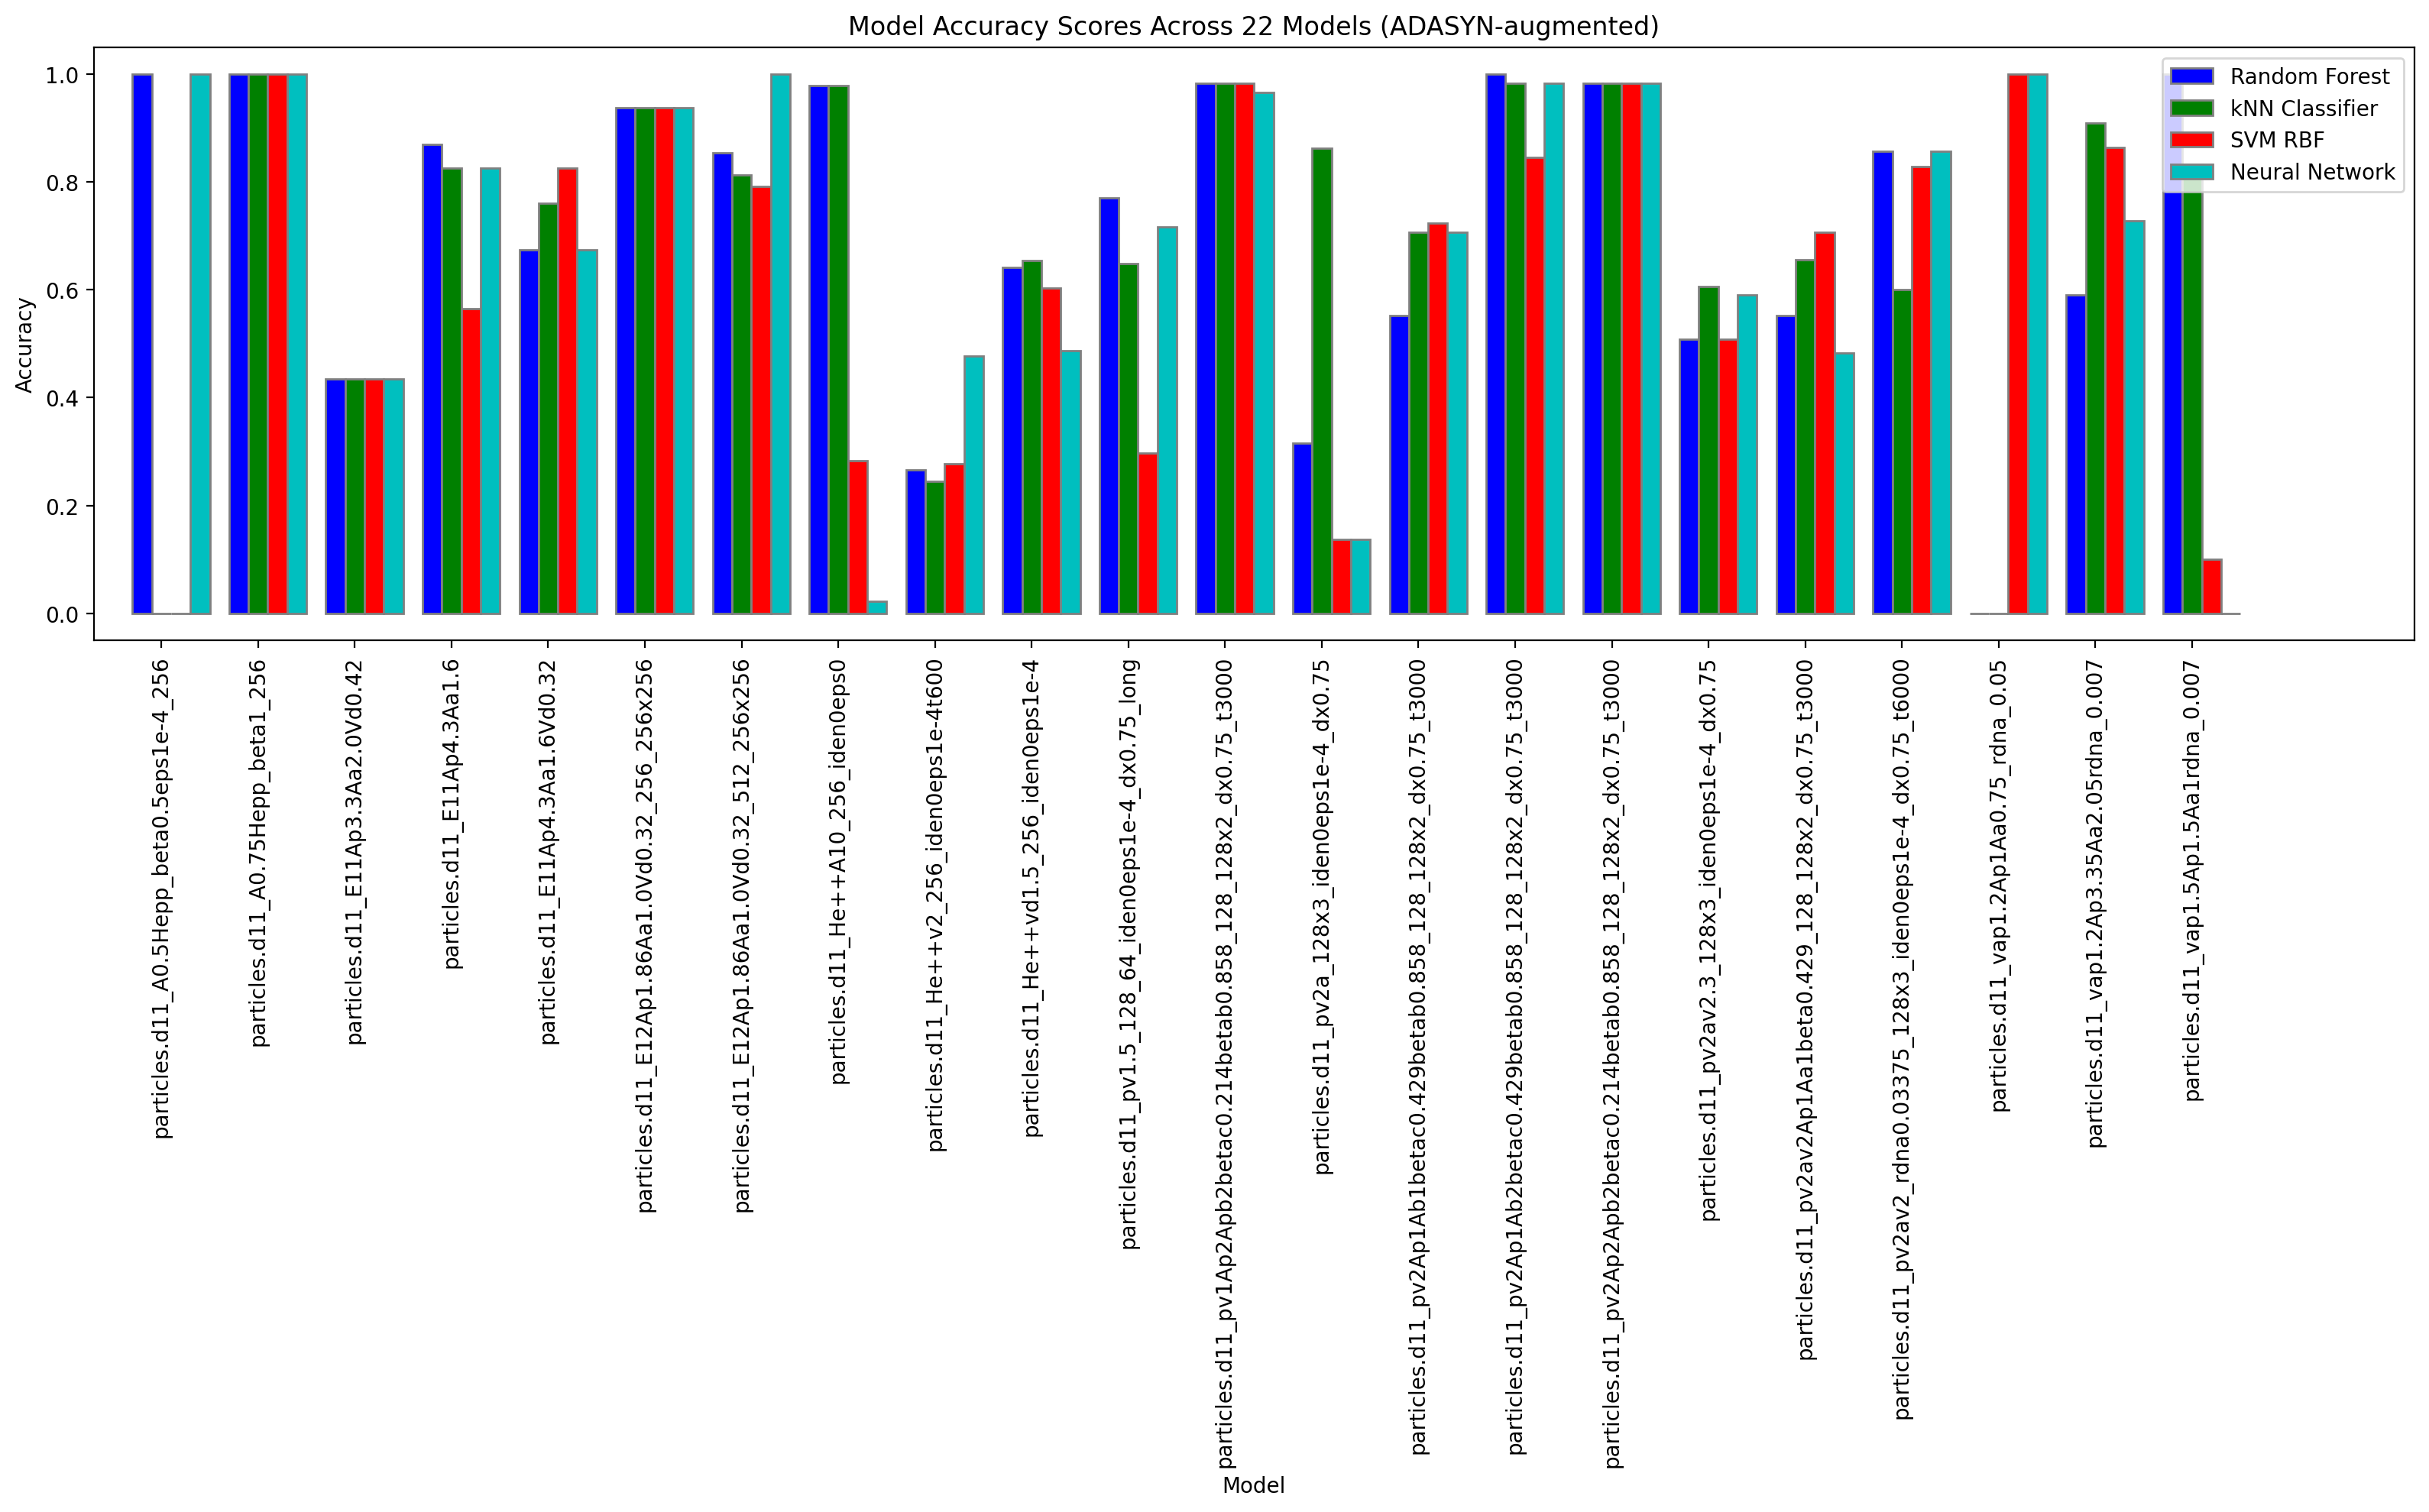

In [10]:
modelnames = np.arange(1, 23)

# Set the bar width and positions
bar_width = 0.2
r1 = np.arange(len(modelnames))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

im, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=200)

# Plotting the bar chart
ax.bar(r1, accuracies_rf_adasyn, color='b', width=bar_width, edgecolor='grey', label='Random Forest')
ax.bar(r2, accuracies_knn_adasyn, color='g', width=bar_width, edgecolor='grey', label='kNN Classifier')
ax.bar(r3, accuracies_svm_adasyn, color='r', width=bar_width, edgecolor='grey', label='SVM RBF')
ax.bar(r4, accuracies_mlp_adasyn, color='c', width=bar_width, edgecolor='grey', label='Neural Network')

# Adding labels and title
ax.set(xlabel='Model', ylabel='Accuracy', title='Model Accuracy Scores Across 22 Models (ADASYN-augmented)',\
       ylim=[-0.05,1.05], xlim=[-0.5,23.5])
plt.xticks([r + bar_width for r in range(len(modelnames))], simfiles, rotation=90)

# Adding legend
ax.legend()

plt.tight_layout()
plt.show()